In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")

from src.context_aware.config import ModelConfig, TrainingConfig, DatasetConfig
from src.DatasetManager import DatasetConvertor 
from src.context_aware.preprocessing import PreparingDataset
from src.context_aware.models import createModel
from src.context_aware.training import trainModel
from src.context_aware.evaluation import evaluateModel

In [7]:
rawDatasetFolder = "../../data/raw"

verbose = True
mapping = {"forward": "fr", "backward": "bk"}
dpdr_params = [
    {"dbParameter": 0.01, "alpha": 0.01, "mode": "fixed"}
]

direction = "forward"
datasetConverter = DatasetConvertor(rawDatasetFolder)
datasetConverter.processDataset(direction=direction, **dpdr_params[0])
thumbDataUnit = datasetConverter.getDataUnit(f"thumb_{mapping[direction]}")

lenWindow = 20
datasetConfig = DatasetConfig.initialize(len_window=lenWindow, data_augment=True)
trainData, testData = PreparingDataset(thumbDataUnit, datasetConfig, verbose=False)
(sources, _, lastTranmittedContext, _, _, _, _, _) = trainData
print(sources.shape)
print(lastTranmittedContext.shape)

========== Thumb ============
Forward: Compression rate: 0.2231
========== Index ============
Forward: Compression rate: 0.2456
========== Middle ============
Forward: Compression rate: 0.2491
(62400, 20, 3)
(62400, 1, 3)


In [8]:
modelConfig = ModelConfig.from_dataset(datasetConfig, trainData)
model, device = createModel(modelConfig)

trainingConfig = TrainingConfig()
best_model, avg_train_loss_history, avg_test_loss_history = trainModel(
    model, trainData, testData, trainingConfig, verbose=verbose
)

Size of train loader: 8, Size of test loader: 6
Used device: cuda:0
Size of model: 31841
TrafficPredictorContextAssisted(
  (dbf2traffic): DeadFeaturesToTrafficLayer(
    (input_layer): Sequential(
      (0): Linear(in_features=231, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.8, inplace=False)
    )
    (hidden_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.8, inplace=False)
      )
    )
    (trans2transmission_layer): Linear(in_features=64, out_features=20, bias=True)
    (sigmoid): Sigmoid()
    (trans2traffic_layer): Linear(in_features=84, out_features=1, bias=True)
    (trans2trafficClass_layer): Linear(in_features=84, out_features=21, bias=True)
  )
  (contextAdjus

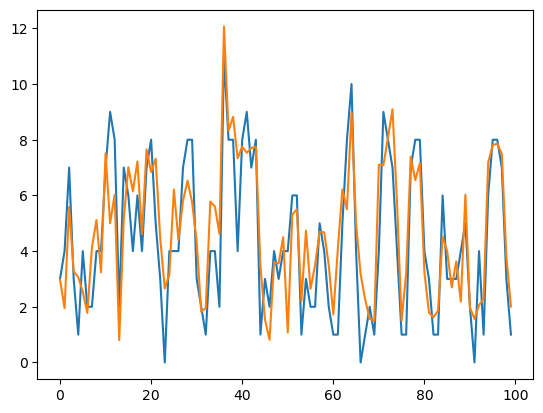

In [9]:
datasetConfig = DatasetConfig.initialize(len_window=lenWindow, data_augment=False)
_, testData = PreparingDataset(thumbDataUnit, datasetConfig, verbose=False)
traffic_predictor, device = createModel(modelConfig)
traffic_predictor.load_state_dict(best_model)
results = evaluateModel(traffic_predictor, testData)

plt.plot(results['trafficTarget_actual'][0:100])
plt.plot(results['trafficTarget_predicted'][0:100])
plt.show()